# CHAPTER 8 어텐션

## 8.1 어텐션의 구조

### 8.1.1 seq2seq의 문제점

<img src='./img/8/seq2seq.png' width=500>

기존에 구현한 seq2seq 모델의 Encoder는 아무리 긴 문장이라도 고정 길이의 벡터로 변환함  
따라서 필요한 정보가 벡터에 다 담기지 못할 수 있음  

### 8.1.2 Encoder 개선

<img src='./img/8/encoder_1.png' width=600>

전에 구현한 모델은 LSTM 계층의 마지막 은닉 상태만을 Decoder에 전달함  
  
하지만 위 그림처럼 각 시각(각 단어)의 LSTM 계층의 은닉 상태 벡터를 모두 이용하면  
입력된 단어와 같은 수의 벡터를 얻을 수 있고,  
따라서 Encoder는 '하나의 고정 길이 벡터'라는 제약에서 해방될 수 있음

<img src='./img/8/encoder_2.png' width=350>

각 시각의 은닉 상태에는 직전에 입력된 단어에 대한 정보가 많이 포함되어 있음  
따라서 Encoder가 출력하는 hs 행렬은 각 단어에 해당하는 벡터들의 집합이라고 볼 수 있음

### 8.1.3 Decoder 개선 ①

<img src='./img/8/decoder_1.png' width=800>

전에 구현한 seq2seq에서는 Encoder의 LSTM 계층의 '마지막' 은닉 상태를 Decoder LSTM 계층의 '첫' 은닉 상태로 사용  
  
개선한 Encoder는 각 단어에 대응하는 LSTM 계층의 은닉 상태 벡터를 hs로 모아서 출력하는데,  
이 중 마지막 줄만 빼내어 Decoder에 전달한 것  

<img src='./img/8/decoder_2.png' width=800>

개선한 Encoder가 출력하는 hs 전부를 활용할 수 있도록 Decoder도 개선해야 함  
  
'나 = I'나 '고양이 = cat'과 같이  
'도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라내는 작업을 수행하기 위해  
필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 구조를 '어텐션'이라고 부름  
  
----  
  
< 참고 > 단어(혹은 문구)의 대응 관계를 나타내는 정보를 얼라인먼트(alignment)라고 함   

----
  
이를 구현하기 위해 '어떤 계산'을 수행하는 계층을 추가  
'어떤 계산'은 Encoder로부터 받는 hs와 시각별 LSTM 계층의 은닉 상태, 이 두 가지를 입력 받음  
여기에서 필요한 정보만 골라 위의 Affine 계층으로 출력함  
  
단어들의 얼라인먼트를 추출하는 것은 각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 hs에서 골라내는 것과 같음  
하지만 골라내는 작업은 미분을 할 수 없어 오차역전파법을 사용할 수 없기 때문에,  
모든 것을 대상으로 각 단어의 중요도(기여도)를 나타내는 '가중치'를 별도로 계산함

<img src='./img/8/decoder_3.png' width=600>

위 그림과 같이 각 단어의 중요도를 나타내는 '가중치(기호 a)'를 이용  
a는 각 원소가 0.0 ~ 1.0 사이의 스칼라(단일 원소)이며,  
모든 원소의 총합은 1  
이 가중치 a와 각 단어의 벡터 hs로부터 가중 합(weight sum)을 구하여 우리가 원하는 벡터를 얻으며,  
이 벡터를 '맥락 벡터'라고 부르고, 기호로는 c로 표기함  
  
이 과정이 '선택'하는 작업을 대체함

 <img src='./img/8/decoder_4.png' width=600>

a와 hs를 가중합하기 위해서는 위 그림과 같은 변환 과정이 필요함  
  
여기서, repeat 부분은 넘파이의 브로드캐스트 기능을 사용해도 되므로 생략 가능함

In [1]:
# a와 hs로부터 c를 구하는 과정 예시

import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5,1).repeat(4, axis=1)
print(ar.shape)

t = hs*ar
print(t.shape)

c = np.sum(t, axis=0)
print(c.shape)

(5, 4)
(5, 4)
(4,)


In [2]:
# 미니배치 처리용 가중합 구현

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
print(ar.shape)

t = hs*ar
print(t.shape)

c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 5, 4)
(10, 4)


가중합 계산 그래프는 다음과 같다

<img src='./img/8/decoder_5.png' width=300>

'Repeat' 노드를 사용해 a를 복제하고 '$\times$' 노드로 원소별 곱을 계산한 다음 'Sum'노드로 합을 구함  
  
역전파에서 Repeat 노드와 Sum 노드는 서로 반대가 됨  
'Repeat 노드의 역전파는 Sum 노드', 'Sum 노드의 역전파는 Repeat 노드'

멕락 벡터를 구하는 __Weight Sum 계층__의 구현

In [3]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeat의 역전파
        
        return dhs, da

### 8.1.4 Decoder 개선 ②

각 단어의 가중치 a를 구하는 방법

<img src='./img/8/decoder_6.png' width=400>

Decoder의 LSTM 계층의 은닉 상태 벡터 h와 Encoder에서 받은 hs의 각 단어 벡터가 얼마나 비슷한가를 수치로 나타내가 위해서 벡터의 '내적'을 이용함  
벡터 $a=(a_1, a_2, \cdots, a_n)$와 $b=(b_1, b_2, \cdots, b_n)$의 내적은 다음과 같다.  
  
$a\cdot b = a_1b_1+a_2b_2+\cdots a_nb_n$  
  
이는 '두 벡터가 얼마나 같은 방향을 향하고 있는가'를 의미하므로 '유사도'를 표현하는 척도로 사용할 수 있음

<img src='./img/8/decoder_7.png' width=500>

위 그림과 같이 벡터의 내적을 이용해 h와 hs의 각 단어 벡터와의 유사도를 구하고 그 결과인 점수(score)는 s라고 표기함

<img src='./img/8/decoder_8.png' width=500>

위에서 구한 점수 s를 소프트맥스 함수로 정규화하여 가중치 a를 구함  
따라서 a의 각 원소는 0.0 ~ 1.0 사이의 값이 되고,  
모든 원소의 총합은 1이 됨

In [4]:
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1) # 여기서도 repeat은 브로드캐스트를 사용하여 생략 가능

t = hs * ar
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


a를 구하는 계산 그래프는 다음과 같다

<img src='./img/8/decoder_9.png' width=300>

각 단어의 가중치 a를 구하는 __Attention Weight 계층__의 구현

In [5]:
import numpy as np
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * ar
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)
        
        return dhs, dh

### 8.1.5 Decoder 개선 ③

<img src='./img/8/attention_1.png' width=800>

앞에서 구현한 Weight Sum 계층과 Attention Weight 계층을 하나로 결합하면 위 그림과 같다.  
멕락 벡터를 구하는 계산 그래프의 전체 모습  
  
Attention Weight 계층은 Encoder가 출력하는 각 단어의 벡터 hs에 주목하여 해당 단어의 가중치 a를 구하고,  
이어서 Weight Sum 계층이 a와 hs의 가중합을 계산하여 맥락 벡터 c를 구함  
  
이 일련의 계산을 수행하는 계층이 바로 Attention 계층  
  
정리하면, Attention 계층은 Encoder가 주는 정보 hs에서 중요한 원소에 주목하여,  
그것을 바탕으로 맥락 벡터를 구해 위쪽 계층인 Affine 계층으로 전파함

__Attention 계층__ 구현  
  
\* 각 단어의 가중치를 나중에 참조할 수 있도록 attention_weight라는 인스턴수 변수에 저장함

In [6]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

<img src='./img/8/attention_2.png' width=800>

Attention 계층을 갖춘 Decoder의 구성은 위의 그림과 같다. 
  
Affine 계층에는 Attention에서 출력하는 '맥락 벡터'와 LSTM의 출력인 '은닉 상태 벡터', 두 개의 벡터를 연결하여 입력됨

<img src='./img/8/attention_3.png' width=800>

다수의 Attention 계층을 모아 __Time Attention 계층__으로 구현

In [7]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
        
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
            
        return out
    
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

## 8.2 어텐션을 갖춘 seq2seq 구현

### 8.2.1Encoder 구현

전에 구현한 Encoder 클래스에서 LSTM 계층의 마지막 은닉 상태 벡터만 반환하던 부분이 모든 은닉 상태 반환으로 바뀜

In [8]:
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
    
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 8.2.2 Decoder 구현

<img src='./img/8/decoder_10.png' width=500>

In [9]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs) # 맥락 벡터
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

### 8.2.3 seq2seq 구현

AttentionEncoder와 AttentionDecoder를 연결하여 __AttentionSeq2seq 구현__  
기존에 구현한 seq2seq 클래스를 상속 받고,  
초기화 메서드에서 다음 두 가지만 수정  
Encoder $\rightarrow$ AttentionEncoder  
Decoder $\rightarrow$ AttentionDecoder

In [14]:
from ch07.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 8.3 어텐션 평가

### 8.3.1 날짜 형식 변환 문제

'날짜 형식 변환' 문제  
영어권에서 사용되는 다양한 날짜 형식을 표준 형식으로 변환하는 것이 목표!  
  
ex)  
"september 27, 1994" $\rightarrow$ "1994-09-27"  
"Jun 17, 2013" $\rightarrow$ "2013-06-18"  
"2/10/93" $\rightarrow$ "1993-02-10"  
  
학습 데이터는  
입력 문장의 길이를 통일하기 위해 공백 문자로 패딩,  
입력과 출력의 구분자는 '\_'를 사용,  
그리고 출력 문자 수가 일정하기 때문에 출력의 끝을 알리는 구분자는 사용하지 않음  

### 8.3.2 어텐션을 갖춘 seq2seq의 학습

학습 코드

In [16]:
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
               batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % ((acc*100)))
        
model.save_params()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 5[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 11[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 17[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 22[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 28[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 33[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 39[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 45[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 51[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 57[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 62[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 68[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 74[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 80[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 86[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 92[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 98[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1978-08-11
---
Q Tuesday, November 22, 2016  

| 에폭 6 |  반복 301 / 351 | 시간 96[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 102[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 108[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
val acc 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 6[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 12[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 19[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 25[s] | 손실 0.00
| 에폭 7 |  반복 101 /

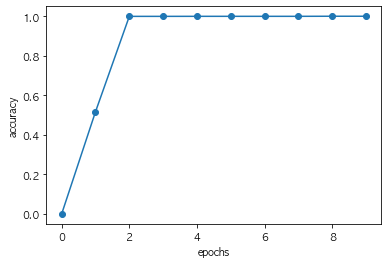

In [24]:
x = np.arange(max_epoch)
y = acc_list

plt.plot(x,y,marker='o')
plt.xlabel('epochs');plt.ylabel('accuracy')
plt.show()

비교 1. 7장에서 구현한 단순한 seq2seq  
  
문장 반전 사용

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 4[s] | 손실 3.34
| 에폭 1 |  반복 41 / 351 | 시간 8[s] | 손실 1.95
| 에폭 1 |  반복 61 / 351 | 시간 12[s] | 손실 1.78
| 에폭 1 |  반복 81 / 351 | 시간 16[s] | 손실 1.70
| 에폭 1 |  반복 101 / 351 | 시간 20[s] | 손실 1.55
| 에폭 1 |  반복 121 / 351 | 시간 24[s] | 손실 1.27
| 에폭 1 |  반복 141 / 351 | 시간 28[s] | 손실 1.16
| 에폭 1 |  반복 161 / 351 | 시간 32[s] | 손실 1.12
| 에폭 1 |  반복 181 / 351 | 시간 36[s] | 손실 1.08
| 에폭 1 |  반복 201 / 351 | 시간 40[s] | 손실 1.06
| 에폭 1 |  반복 221 / 351 | 시간 44[s] | 손실 1.05
| 에폭 1 |  반복 241 / 351 | 시간 48[s] | 손실 1.04
| 에폭 1 |  반복 261 / 351 | 시간 52[s] | 손실 1.04
| 에폭 1 |  반복 281 / 351 | 시간 56[s] | 손실 1.03
| 에폭 1 |  반복 301 / 351 | 시간 60[s] | 손실 1.03
| 에폭 1 |  반복 321 / 351 | 시간 64[s] | 손실 1.03
| 에폭 1 |  반복 341 / 351 | 시간 68[s] | 손실 1.02
Q 10/15/94                     
T 1994-10-15
☒ 1999-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1999-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1999-01-11
---
Q Tuesday, November 22, 2016   

| 에폭 6 |  반복 321 / 351 | 시간 68[s] | 손실 0.98
| 에폭 6 |  반복 341 / 351 | 시간 72[s] | 손실 0.98
Q 10/15/94                     
T 1994-10-15
☒ 1980-01-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1980-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1980-01-11
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☒ 1980-01-11
---
Q Saturday, July 18, 1970      
T 1970-07-18
☒ 1980-01-11
---
Q october 6, 1992              
T 1992-10-06
☒ 1980-01-11
---
Q 8/23/08                      
T 2008-08-23
☒ 1980-01-11
---
Q 8/30/07                      
T 2007-08-30
☒ 1980-01-11
---
Q 10/28/13                     
T 2013-10-28
☒ 1980-01-11
---
Q sunday, november 6, 2016     
T 2016-11-06
☒ 1980-01-11
---
검증 정확도 0.000%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 7 |  반복 21 / 351 | 시간 4[s] | 손실 0.98
| 에폭 7 |  반복 41 / 351 | 시간 8[s] | 손실 0.98
| 에폭 7 |  반복 61 / 351 | 시간 13[s] | 손실 0.98
| 에폭 7 |  반복 81 / 351 | 시간 17[s] | 손실 0.98
| 에폭 7 |  반복 101 / 351 | 시간 21[s] | 손실 0.98
| 에폭 7 |  반복 121 / 351 

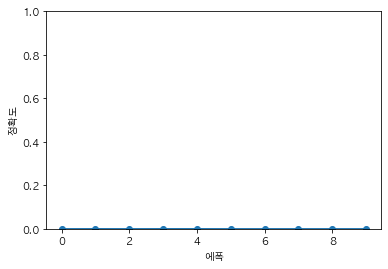

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 ================================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

비교 2. 7장에서 구현한 'peeky'를 적용한 seq2seq  
  
문장 반전 사용

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 5[s] | 손실 2.86
| 에폭 1 |  반복 41 / 351 | 시간 9[s] | 손실 1.89
| 에폭 1 |  반복 61 / 351 | 시간 14[s] | 손실 1.78
| 에폭 1 |  반복 81 / 351 | 시간 20[s] | 손실 1.70
| 에폭 1 |  반복 101 / 351 | 시간 24[s] | 손실 1.57
| 에폭 1 |  반복 121 / 351 | 시간 29[s] | 손실 1.30
| 에폭 1 |  반복 141 / 351 | 시간 34[s] | 손실 1.16
| 에폭 1 |  반복 161 / 351 | 시간 39[s] | 손실 1.10
| 에폭 1 |  반복 181 / 351 | 시간 45[s] | 손실 1.07
| 에폭 1 |  반복 201 / 351 | 시간 49[s] | 손실 1.05
| 에폭 1 |  반복 221 / 351 | 시간 54[s] | 손실 1.04
| 에폭 1 |  반복 241 / 351 | 시간 59[s] | 손실 1.04
| 에폭 1 |  반복 261 / 351 | 시간 64[s] | 손실 1.03
| 에폭 1 |  반복 281 / 351 | 시간 69[s] | 손실 1.02
| 에폭 1 |  반복 301 / 351 | 시간 74[s] | 손실 1.01
| 에폭 1 |  반복 321 / 351 | 시간 79[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 84[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
☒ 1971-11-11
---
Q thursday, november 13, 2008  
T 2008-11-13
☒ 1973-01-11
---
Q Mar 25, 2003                 
T 2003-03-25
☒ 1983-03-03
---
Q Tuesday, November 22, 2016   

| 에폭 6 |  반복 301 / 351 | 시간 73[s] | 손실 0.00
| 에폭 6 |  반복 321 / 351 | 시간 78[s] | 손실 0.00
| 에폭 6 |  반복 341 / 351 | 시간 83[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
☑ 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
☑ 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
☑ 2003-03-25
---
Q Tuesday, November 22, 2016   
T 2016-11-22
☑ 2016-11-22
---
Q Saturday, July 18, 1970      
T 1970-07-18
☑ 1970-07-18
---
Q october 6, 1992              
T 1992-10-06
☑ 1992-10-06
---
Q 8/23/08                      
T 2008-08-23
☑ 2008-08-23
---
Q 8/30/07                      
T 2007-08-30
☑ 2007-08-30
---
Q 10/28/13                     
T 2013-10-28
☑ 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
☑ 2016-11-06
---
검증 정확도 99.980%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 5[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 10[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 15[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 20[s] | 손실 0.00
| 에폭 7 |  반복 101 / 35

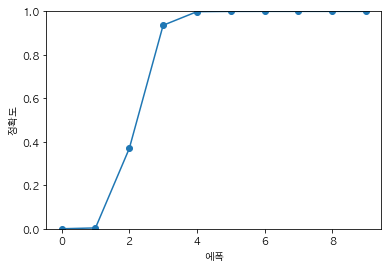

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 ================================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

# 엿보기(Peeky) 설정 ===============================================
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

7장에서 구현했던 단순한 seq2seq, Peeky를 적용한 seq2seq, AttentionSeq2seq 세 가지 모델을 비교하였을 때,  
seq2seq 모델은 10 에폭에도 정확도가 0%인 반면  
Peeky를 적용한 seq2seq와 AttentionSeq2seq 모델은 정확도가 아주 높게 나옴  
  
(세 모델 모두 입력 반전 사용함)

### 8.3.3 어텐션 시각화

Attention 계층은 각 시각의 어텐션 가중치를 인스턴스 변수로 보관하고 있음  
이를 이용하여 어텐션이 시계열 변환을 수행할 때, 어느 원소에 주의를 기울이는지 시각화하여 확인   
  
가로 축 : 입력 문장  
세로 축 : 출력 문장  
맵의 각 원소는 밝을수록 값이 큼(1에 가까움)

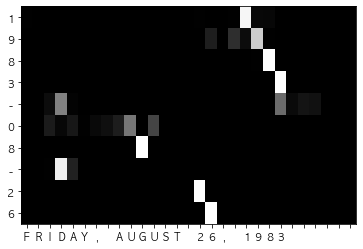

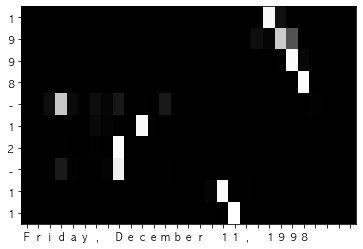

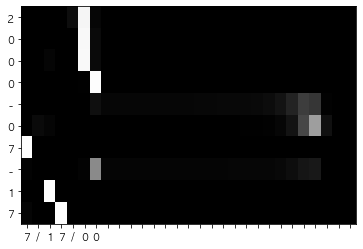

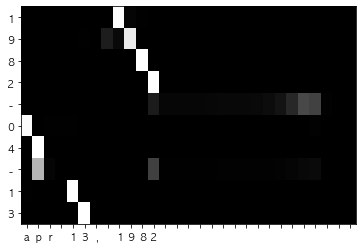

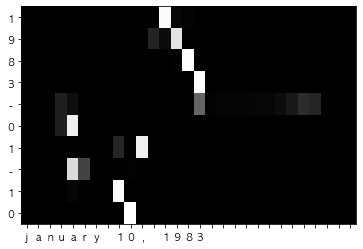

In [26]:
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0

def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()

np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)

## 8.4 어텐션에 관한 남은 이야기

### 8.4.1 양방향 RNN

지금까지 구현한 모델은 왼쪽에서 오른쪽으로 시계열 데이터를 읽음  
주변 정보를 균형있게 담고 싶은 경우엔, LSTM을 양방향으로 처리하도록 할 수 있으며,  
이를 양방향 LSTM(양방향 RNN)이라고 함  

<img src='./img/8/bilstm.png' width=700>

위 그림과 같이 양방향 LSTM에서는 지금까지의 LSTM 계층에 더해 역방향으로 처리하는 LSTM 계층도 추가함  
그리고 각 시각에서는 이 두 LSTM 계층의 은닉상태를 연결시킨 벡터를 최종 은닉 상태로 처리 함  
  
이로써, 각 단어에 대응하는 은닉 상태 벡터에는 양쪽 방향으로부터의 균형 잡힌 정보를 집약할 수 있음  
  
역방향 LSTM 입력 문장의 단어들을 반대로 순서를 바꾸고,  
두 LSTM 계층의 출력을 연결하여 구현

In [27]:
class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful) # 순방향(왼쪽->오른쪽)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful) # 역방향(오른쪽->왼쪽)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2) # 양쪽 합침
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

### 8.4.2 Attention 계층 사용 방법

Attention 계층을 LSTM 계층과 Affine 계층 사이에 삽입하여 구현했었으나,  
Attention 계층을 반드시 그 위치에 배치해야할 필요는 없음  
따라서 여러 변형이 가능함  
  
ex)  
<img src='./img/8/attention2.png' width=500>  
Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio: "Neural machine translation by jointly learning to align and translate." arXiv prepring arXiv:1409.0472(2014).  

  
위와 같이 Attention 계층의 출력(맥락 벡터)이 다음 시각의 LSTM 계층에 입력되도록 연결하게 되면,  
LSTM 계층이 맥락 벡터의 정보를 이용할 수 있음  

### 8.4.3 seq2seq 심층화와 skip 연결

어텐션을 갖춘 seq2se1도 층을 깊게 쌓으면 표현력이 높은 모델을 만들 수 있음  
Encoder와 Decoder에서는 같은 층수의 LSTM 계층을 이용하는 것이 일반적  
  
다만, 층을 깊게 할 경우에는 일반화 성능을 떨어뜨리지 않도록 하는 것이 중요함  
드롭아웃과 가중치 공유 등의 기술이 효과적  
  
또한, 층을 깊게 할 때 RNN의 깊이 방향 기울기 소실에는 skip 연결(skip connetcion)(잔차 연결(residual connection) 혹은 숏컷(short-cut)이라고도 함)이 효과적임  
  
<img src='./img/8/skip_connection.png' width=250>  
  
skip 연결은 '계층을 건너뛰는 연결'로 skip 연결의 접속부에서는 2개의 출력이 더해지며,  
덧셈은 역전파 시 기울기를 그대로 흘려 보내므로,
기울기가 소실(혹은 폭발)되지 않고 전파됨

## 8.5 어텐션 응용

### 8.5.1 구글 신경망 기계 번역(GNMT)

기계 번역은 '규칙 기반 번역' $\rightarrow$ '용례 기반 번역' $\rightarrow$ '통계 기반 변역'으로 옮겨옴  
현재는 '신경망 기계 번역(Neural Machine Translation(NMT)'이 주목받고 있음  
  
NMT라는 용어는 기존의 통계 기반 번역과 대비되는 형태로 사용되다가, 최근에는 seq2seq를 사용한 기계 번역의 총칭으로 사용되고 있음  
  
그 중 구글 신경망 기계번역(GNMT)를 보면,  
Encoder, Decoder, Attention으로 구성되어 있음  
또한, LSTM 계층의 다층화, 양방향 LSTM(Encoder의 첫 번째 계층만), skip 연결 등을 적용하였고,  
분산 학습을 수행하고 있음  

### 8.5.2 트랜스포머

RNN는 이전 시각에 계산한 결과를 이용하여 순서대로 계산하기 때문에 병렬 계산을 할 수 없음  
따라서 RNN을 없애는 연구(혹은 병렬 계산할 수 있는 RNN 연구)가 활발하게 진행 중임  
  
논문 'Attention is all you need'에서 제안한 기법인 트랜스포머(Transformer) 모델은  
RNN 대신 어텐션을 사용함  
  
<img src='./img/8/self_attention.png' width=400>  
  
하나의 시계열 데이터를 대상으로 한 어텐션인 셀프어텐션이라는 기술을 사용하는데,    
이는 위 그림처럼 두 입력선이 모두 하나의 시계열로부터 나오며  
따라서 하나의 시계열 데이터 내에서의 원소 간 대응관계를 구함  
  
Feed Forward 계층은 피드포워드 신경망(시간 방향으로 독립적으로 처리하는 신경망)을 나타냄  
은닉층 1개이고 활성화 함수로 ReLU를 이용한 완전연결계층 신경망임  
  
이 외에도 skip 연결, 계층 정규화와 다수의 어텐션을 (병렬로) 이용하거나 시계열 데이터의 위치 정보를 인코딩하는 위치 인코딩 등의 기법을 사용함  
  
트랜스 포머를 이용하면 계산량을 줄이고 GPU를 이용한 병렬 계산도 가능함  

### 8.5.3 뉴럴 튜링 머신(NTM)

'외부 메모리를 통한 확장'  
RNN의 외부에 정보 저장용 메모리 기능을 배치하고, 어텐션을 이용하여 그 메모리로부터 필요한 정보를 읽거나 쓰는 방법에 대한 연구가 이뤄지고 있고,  
그 중 유명한 연구로 뉴럴 튜링 머신(Neural Turing Maching, NTM)이 있음  
  
NTM은 외부 메모리를 읽고 쓰면서 시계열 데이터를 처리함  
메모리 조작을 '미분 가능'한 계산으로 구축해서 메모리 조작 순서도 데이터로부터 학습할 수 있음  
각 시각에서 LSTM 계층의 은닉 상태를 Write Head 계층이 받아서 필요한 정보를 메모리에 쓰고  
Read Head 계층이 메모리로부터 정보를 읽어 들여 다음 시각의 LSTM 계층으로 전달함  
  
여기서 데이터를 읽거나 쓸 때 데이터를 선택하기 위한 방법으로 가중치를 이용하는 어텐션을 사용함  
  
NMT는 2개의 어텐션을 이용  
- 컨텐츠 기반 어텐션 : 입력으로 주어진 어느 벡터(질의 벡터)와 비슷한 벡터를 메모리로부터 찾아내는 용도
- 위치 기반 어텐션 : 이전 시각에서 주목한 메모리의 위치(메모리의 각 위치에 대한 가중치)를 기준으로 그 전후로 이동(시프트)하는 용도  
  
NTM은 외부 메모리를 사용함으로써 알고리즘을 학습하는 능력을 얻음